# Almgren-Chriss Optimal Execution - Efficient Frontier approach

## Syllabus

1. Almgren-Chriss framework
2. Efficient frontier for implementation shortfall
3. Efficient frontier for VWAP
4. Efficient forntier for TWAP

## 1. Almgren-Chriss framework

The **Almgren-Chriss framework** (1999) is a mathematical model that looks to

- Estimate the optimal pace to build/unwind a trading position, issues often faced by brokers and traders (but has not seen as much interest from statisticians, economists and econophysicists in the past decades);
- Allows one to graphically represent the trade-off between slow/fast execution;
- Ease to choose one's own prefered approach to model market impact costs;
- Avoids the temptation of modelling the market as a physical system fully enclosed in its own data (*physics envy*);
- Designed from a bottom-top approach: the modelling is based on the execution process itself;
- Provides a multitude of modelling approaches to compute the slow/fast execution trade-off (e.g. dynamic programming, stochastic control, reinforcement learning, etc.).

We will present 2 approaches to solve the Almgren-Chriss model:

1. Efficient Frontier (original method)
2. Dynamic Programming

**Assumptions**

- *Trading trajectory*

$$ x_0 = X $$

$$ n_k = x_k - x_{k-1} $$

$$ x_k = X - \sum_{j=1}^k n_j = \sum_{j=k+1}^N n_k, \, \, \, \,\, \, \,\, \, \,   k=0,...,N $$

- *Price trajectory*

$$ S_k = S_{k-1} + \sigma  \sqrt{\tau} \zeta_k - \tau g(\frac{n_k}{\tau}) $$

$$ g(v) = \gamma v $$

$$ S_k = S_0 + \sigma  \sqrt{\tau} \sum_{j=1}^k \zeta_j - \gamma (X - x_k) $$

- *Temporary market impact*

$$ h(v) = \varepsilon sign(n_i) + \frac{\eta}{\tau} n_i $$

$$ \tilde S_k = S_{k-1} - h(\frac{n_k}{\tau}) $$

In [1]:
import numpy as np

# Utilities

def g(x, gamma=1.0):
    """
    Permanent market impact.
    """
    return gamma * x

def h(x, tau=1.0, epsilon=1.0, eta=1.0):
    """
    Temporary market impact.
    """
    return epsilon*np.sign(x) + eta*(x/tau)

## 2. Efficient frontier for implementation shortfall

### 2.1. Optimization

**Moments**

$$ X_N = X S_0 - \sum_{i=1}^N n_i \tilde S_i $$

$$ \mathbb{E}(X_N) = \sum_{i=1}^N \tau x_i g(\frac{n_i}{\tau}) + \sum_{i=1}^{N} n_i h(\frac{n_i}{\tau}) = \frac{1}{2} \gamma X^2 + \varepsilon \sum_{i=1}^N |n_i| + \frac{\eta-0.5\gamma \tau}{\tau} \sum_{i=1}^N n_i^2 $$

$$ \mathbb{V}(X_N) = \sigma^2 \sum_{i=1}^N \tau x_i^2 $$

Refresher:

$$ x_t = X - \sum_{j=1}^t n_j = \sum_{j=t+1}^N n_j $$

In [46]:
# Moments

def expectation_IS(N, tau=1.0, gamma=1.0, eta=1.0, eps=1.0):
    """
    Expectation of implementation shortfall.
    """
    exp = 0.5*gamma*X**2 + eps*np.sum(N) + (eta - 0.5*gamma*tau)/tau * np.sum(N**2)
    return exp

def variance_IS(N, sigma=0.3, tau=1.0):
    """
    Variance of implementation shortfall.
    """
    var = 0
    t = - 1
    while t < len(N) - 1:
        t = t + 1
        temp = (X - np.sum(N[0:t])) ** 2
        var = var + temp
    
    var = tau * (sigma**2) * var
    return var

# Objective function

def objective_IS(N):
    """
    Objective function for implementation shortfall.
    """
    obj = expectation_IS(N) + risk * variance_IS(N)
    return obj

**Optimization**

$$ (n_1^*,...,n_N^*) = \min_{0<n_i<X} \mathbb{E}(X_N) + \lambda * \mathbb{V}(X_N) $$

In [122]:
# Parameters
nb_T = 50
x0 = np.zeros((nb_T, 1))
X = 40000
risk = 0.05

# Optimization
from scipy.optimize import minimize

bnds = tuple((0.0, X) for x in range(len(x0)))
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - X})

opt = minimize(objective_IS, x0, method='SLSQP', bounds=bnds, constraints=cons)
N_opt = np.array(opt.x)

print('Liquidation trajectory:\n')
print(np.matrix(opt.x.round(0)).T)

print('\nTotal number of shares:')
print(np.sum(opt.x))

print('\nExpectation E(x):')
print(expectation_IS(opt.x))

print('\nVariance V(x):')
print(variance_IS(opt.x))

Liquidation trajectory:

[[ 3620.]
 [ 3293.]
 [ 2994.]
 [ 2723.]
 [ 2476.]
 [ 2254.]
 [ 2050.]
 [ 1863.]
 [ 1695.]
 [ 1544.]
 [ 1401.]
 [ 1277.]
 [ 1159.]
 [ 1056.]
 [  960.]
 [  873.]
 [  795.]
 [  724.]
 [  659.]
 [  599.]
 [  544.]
 [  495.]
 [  453.]
 [  412.]
 [  375.]
 [  342.]
 [  310.]
 [  284.]
 [  260.]
 [  236.]
 [  213.]
 [  199.]
 [  181.]
 [  168.]
 [  152.]
 [  140.]
 [  128.]
 [  117.]
 [  110.]
 [  102.]
 [   94.]
 [   88.]
 [   84.]
 [   80.]
 [   75.]
 [   71.]
 [   71.]
 [   70.]
 [   67.]
 [   66.]]

Total number of shares:
40000.0

Expectation E(x):
838002891.072

Variance V(x):
832574043.449


We have the optimal trajectory, now we can detail the liquidation process from the first day till the last:

In [125]:
def liquidation_history(N_opt, X):
    """
    Prints out the liquidation history of the optimal execution.
    """
    hist = np.zeros((len(N_opt), 1))
    hist[0] = X
    
    for i in range(1, len(N_opt)):
        hist[i] = hist[i-1] - N_opt[i]
    
    return hist

hist_opt = liquidation_history(N_opt, X)

print('Liquidation history:\n')
print(hist_opt.round(0))

Liquidation history:

[[ 40000.]
 [ 36707.]
 [ 33713.]
 [ 30990.]
 [ 28514.]
 [ 26260.]
 [ 24210.]
 [ 22346.]
 [ 20651.]
 [ 19107.]
 [ 17706.]
 [ 16429.]
 [ 15270.]
 [ 14214.]
 [ 13255.]
 [ 12381.]
 [ 11586.]
 [ 10862.]
 [ 10204.]
 [  9605.]
 [  9061.]
 [  8566.]
 [  8113.]
 [  7701.]
 [  7326.]
 [  6984.]
 [  6674.]
 [  6390.]
 [  6131.]
 [  5894.]
 [  5681.]
 [  5482.]
 [  5301.]
 [  5134.]
 [  4982.]
 [  4842.]
 [  4714.]
 [  4597.]
 [  4487.]
 [  4385.]
 [  4291.]
 [  4203.]
 [  4119.]
 [  4039.]
 [  3964.]
 [  3893.]
 [  3823.]
 [  3753.]
 [  3686.]
 [  3620.]]


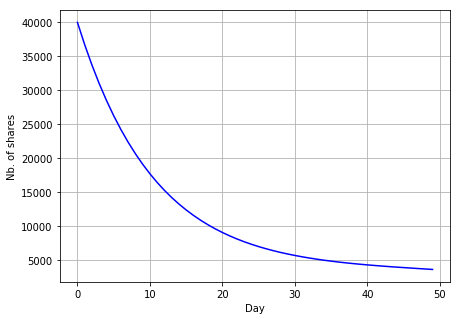

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(hist_opt, color='blue', lw=1.5)
plt.grid(True)
plt.xlabel('Day')
plt.ylabel('Nb. of shares')
plt.show()

### 2.2. Hyperparameter testing

In [130]:
def efficient_frontier_IS(X, risk, nb_T, tau=1.0, gamma=1.0, eta=1.0, eps=1.0, plot='True'):
    
    def expectation_IS(N):
        """
        Expectation of implementation shortfall.
        """
        exp = 0.5*gamma*X**2 + eps*np.sum(N) + (eta - 0.5*gamma)/tau * np.sum(N**2)
        return exp

    def variance_IS(N, sigma=0.3):
        """
        Variance of implementation shortfall.
        """
        var = 0
        t = - 1
        while t < len(N) - 1:
            t = t + 1
            temp = (X - np.sum(N[0:t])) ** 2
            var = var + temp
        var = tau * (sigma**2) * var
        return var
    
    def objective_IS(N):
        """
        Objective function for implementation shortfall.
        """
        obj = expectation_IS(N) + risk * variance_IS(N)
        return obj
    
    def optimization_IS():
        """
        Optimal execution with optimization for implementation shortfall.
        """
        x0 = np.zeros((nb_T, 1))
        bnds = tuple((0.0, X) for x in range(len(x0)))
        cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - X})
        opt = minimize(objective_IS, x0, method='SLSQP', bounds=bnds, constraints=cons)
        N = np.array(opt.x)
        return N
    
    N_opt = optimization_IS()
    
    def liquidation_history(N_opt, X):
        """
        Prints out the liquidation history of the optimal execution.
        """
        hist = np.zeros((len(N_opt), 1))
        hist[0] = X
        for i in range(1, len(N_opt)):
            hist[i] = hist[i-1] - N_opt[i]
        return hist
    
    hist_opt = liquidation_history(N_opt,X)

    def plot_liquidation():
        plt.figure(figsize=(7,5))
        plt.plot(hist_opt, color='blue', lw=1.5)
        plt.grid(True)
        plt.xlabel('Time')
        plt.ylabel('Nb. of shares')
        plt.show()
    
    if plot=='True':
        plot_liquidation()
    
    res = hist_opt.round(0), expectation_IS(N_opt), variance_IS(N_opt)
    
    return res

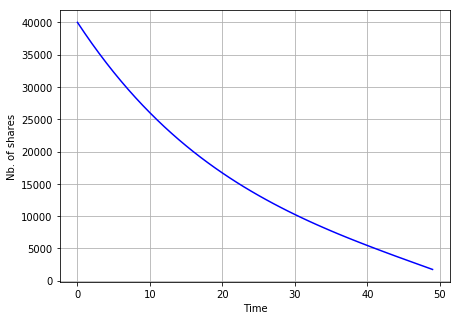

array([[ 40000.],
       [ 38329.],
       [ 36721.],
       [ 35182.],
       [ 33704.],
       [ 32283.],
       [ 30924.],
       [ 29615.],
       [ 28360.],
       [ 27157.],
       [ 26003.],
       [ 24893.],
       [ 23826.],
       [ 22806.],
       [ 21823.],
       [ 20881.],
       [ 19972.],
       [ 19101.],
       [ 18264.],
       [ 17457.],
       [ 16680.],
       [ 15933.],
       [ 15209.],
       [ 14514.],
       [ 13844.],
       [ 13196.],
       [ 12570.],
       [ 11963.],
       [ 11376.],
       [ 10806.],
       [ 10255.],
       [  9717.],
       [  9195.],
       [  8688.],
       [  8196.],
       [  7712.],
       [  7240.],
       [  6781.],
       [  6331.],
       [  5889.],
       [  5455.],
       [  5025.],
       [  4604.],
       [  4185.],
       [  3770.],
       [  3364.],
       [  2957.],
       [  2552.],
       [  2149.],
       [  1745.]])

In [131]:
efficient_frontier_IS(X=40000, risk=2*10**(-7), nb_T=50,
                      tau=0.5,  # 0.75
                      gamma=2.5*10**(-7),
                      eta=2.5*10**(-6),
                      eps=0.0625)[0]

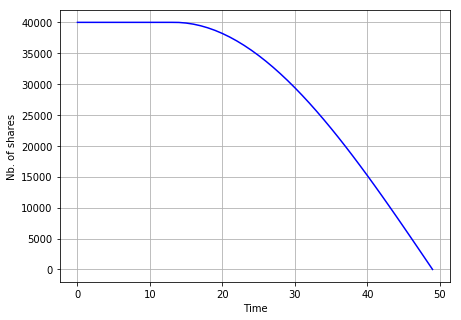

array([[ 40000.],
       [ 40000.],
       [ 40000.],
       [ 40000.],
       [ 40000.],
       [ 40000.],
       [ 40000.],
       [ 40000.],
       [ 40000.],
       [ 40000.],
       [ 40000.],
       [ 40000.],
       [ 40000.],
       [ 40000.],
       [ 39985.],
       [ 39888.],
       [ 39709.],
       [ 39449.],
       [ 39110.],
       [ 38693.],
       [ 38198.],
       [ 37629.],
       [ 36985.],
       [ 36270.],
       [ 35485.],
       [ 34632.],
       [ 33712.],
       [ 32729.],
       [ 31684.],
       [ 30579.],
       [ 29416.],
       [ 28200.],
       [ 26931.],
       [ 25612.],
       [ 24245.],
       [ 22835.],
       [ 21382.],
       [ 19889.],
       [ 18361.],
       [ 16799.],
       [ 15207.],
       [ 13588.],
       [ 11943.],
       [ 10278.],
       [  8594.],
       [  6894.],
       [  5181.],
       [  3459.],
       [  1731.],
       [    -0.]])

In [132]:
efficient_frontier_IS(X=40000, risk=-2*10**(-7), nb_T=50,
                      tau=0.5,
                      gamma=2.5*10**(-7),
                      eta=2.5*10**(-6),
                      eps=0.0625)[0]

### 2.3. Efficient frontier

In [160]:
risks = np.linspace(0.1*10**(-7), 5.0*10**(-7), 50)
risks

array([  1.00000000e-08,   2.00000000e-08,   3.00000000e-08,
         4.00000000e-08,   5.00000000e-08,   6.00000000e-08,
         7.00000000e-08,   8.00000000e-08,   9.00000000e-08,
         1.00000000e-07,   1.10000000e-07,   1.20000000e-07,
         1.30000000e-07,   1.40000000e-07,   1.50000000e-07,
         1.60000000e-07,   1.70000000e-07,   1.80000000e-07,
         1.90000000e-07,   2.00000000e-07,   2.10000000e-07,
         2.20000000e-07,   2.30000000e-07,   2.40000000e-07,
         2.50000000e-07,   2.60000000e-07,   2.70000000e-07,
         2.80000000e-07,   2.90000000e-07,   3.00000000e-07,
         3.10000000e-07,   3.20000000e-07,   3.30000000e-07,
         3.40000000e-07,   3.50000000e-07,   3.60000000e-07,
         3.70000000e-07,   3.80000000e-07,   3.90000000e-07,
         4.00000000e-07,   4.10000000e-07,   4.20000000e-07,
         4.30000000e-07,   4.40000000e-07,   4.50000000e-07,
         4.60000000e-07,   4.70000000e-07,   4.80000000e-07,
         4.90000000e-07,

In [161]:
# risks = [-2*10**(-8), 0.5*10**(-7), 1.0*10**(-7), 1.5*10**(-7), 2.0*10**(-7)]

x = []
y = []

for r in risks:
    temp = efficient_frontier_IS(X=40000, risk=r, nb_T=50,
                                 tau=0.5, gamma=2.5*10**(-7), eta=2.5*10**(-6),
                                 eps=0.0625, plot='False')
    
    x.append(temp[2])  # V(x)
    y.append(temp[1])  # E(x)
    
# print(x)
# print(y)

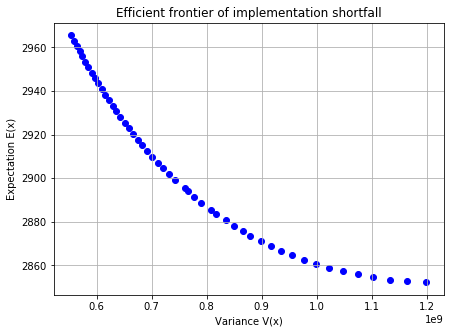

In [162]:
plt.figure(figsize=(7,5))
plt.scatter(x, y, marker='o', color='blue')
plt.grid(True)
plt.xlabel('Variance V(x)')
plt.ylabel('Expectation E(x)')
plt.title('Efficient frontier of implementation shortfall')
plt.show()